# Replicate and Decompose the daily return sequence for investment funds or equity with 500 stock daily return sequence from SP 500
The goal for this project is to replicate the daily return sequence for any investment fund or equity, with the given performance of SP 500 stocks. After the replication, the relative importances of the 500 stocks will be decomposed. Then the training model can be used to predict the future returns of the target fund or equity. 

In [14]:
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np

# Get historical stock price data for S&P 500

In [15]:
def getDailyStockPrices(names,date1,date2):
    stocks=YahooFinancials(names)
    daily_prices_dic = stocks.get_historical_stock_data(date1, date2, 'daily')
    prices=pd.DataFrame(columns=['stock_name','date','open','high','low','close','adjusted_close','volume'])
    k=0
    for name in names:
        temp=daily_prices_dic[name]['prices']
        for i in range(len(temp)):
            try:
                line=[name,temp[i]['formatted_date'],temp[i]['open'],temp[i]['high'],
                     temp[i]['low'],temp[i]['close'],temp[i]['adjclose'],
                     temp[i]['volume']]
                prices.loc[k]=line
                k+=1
            
            except:
                pass
    return prices
    

In [16]:
date1='2011-12-25'
date2='2018-07-12'

In [17]:
stocks_sp500=pd.read_csv('SP500.csv')

In [18]:
sectors=set(stocks_sp500.Sector)

In [19]:
stocks_sp500.head(1)

,Symbol,Name,Sector
0,MMM,3M Company,Industrials


In [20]:
# Get the historic stock data for the first time
#data=getDailyStockPrices(stocks_sp500.Symbol,date1,date2)
#data.to_csv('history_data.csv')
# it takes a while to get the data, just load the saved data
history_data=pd.read_csv('history_data.csv')

# Calculate Future Returns (the returns for today as of yesterday)
yesterday return at i = (price_at_(i+1) -price_at_i)/(price_at_i)

In [21]:
def Calculate_FutureReturns(df,company_col, price_col,date_col):
    Companies=np.unique(df[company_col])
    return_df=pd.DataFrame(index=df.index, columns=['Date','Company','FutureReturns'])
    for company in Companies:
        print (company)
        temp= df[df[company_col]==company].sort_values(date_col)
        index_list=temp.index
        max_index=len(index_list)
        for i in range(max_index):
            if i <max_index-1:
                ret=(temp.loc[index_list[i+1],price_col]-temp.loc[index_list[i],price_col])/temp.loc[index_list[i],price_col]
                return_df.loc[index_list[i],'FutureReturns']=ret 
    return return_df

In [22]:
# Calculate the returns for the first time

#FutureReturns=Calculate_FutureReturns(history_data.copy(),"stock_name", 'close','date')
#FutureReturns['date']=history_data.date
#FutureReturns['Company']=history_data.stock_name
#FutureReturns.sort_values(['Company','Date']).to_csv('Future_returns.csv')

# Since it takes a while to get the results, I save the results to csv file and reload it for  the second and after runs
FutureReturns=pd.read_csv('Future_returns.csv').set_index(['Index'])

# Get each stock's return as a time series strategy

In [23]:
strategy_names=FutureReturns.pivot(index='Date',columns='Company',values='FutureReturns')

In [24]:
strategy_names.to_csv('strategy_sp500.csv')

In [25]:
# In silimar way, generate the return time series data for S&P 500 or other investment funds or equity

# Investment strategy replication and decomposition

In [26]:
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.callbacks import History 
from keras import initializers
from keras import optimizers

Using TensorFlow backend.


In [27]:
strategy_df=pd.read_csv('strategy_SP500_final.csv').sort_values(by=['Date']).drop(['Date'],axis=1)
targets_df=pd.read_csv('target_100.csv').sort_values(by=['Date']).drop(['Date'],axis=1)

 # Check missing data and impute the missing data with mean

In [28]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [29]:
missing_values = missing_values_table(strategy_df)
missing_values

Your selected dataframe has 500 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
strategy93,62,3.7
strategy52,4,0.2
strategy61,4,0.2
strategy69,4,0.2
strategy53,2,0.1
strategy60,2,0.1
strategy62,2,0.1
strategy68,2,0.1
strategy81,2,0.1
strategy63,1,0.1


In [30]:
missing_values = missing_values_table(targets_df)
missing_values

Your selected dataframe has 100 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [31]:
from sklearn.preprocessing import MinMaxScaler,Imputer
imputer = Imputer(strategy = 'mean')
imputer.fit(strategy_df)
# Transform training  data
strategy_df = imputer.transform(strategy_df)

imputer_target = Imputer(strategy = 'mean')
imputer_target.fit(targets_df)
targets_df=imputer_target.transform(targets_df)

# Scale the strategy and target data to [0,1] and Select the number of strategy, the number of time steps for the model

In [32]:
scaler_stra=MinMaxScaler(feature_range=(0, 1))
scaler_stra.fit(strategy_df[:,:])
strategy_scale=scaler_stra.transform(strategy_df[:,:])

In [33]:
def getTargetsList(targets_df,i,j):
    all_target=[]
    for k in range(len(targets_df)):
            temp= list(targets_df[k,i:j])
            all_target.append(temp)
    return all_target

In [34]:
scaler=MinMaxScaler(feature_range=(0, 1))
scaler.fit(targets_df[:,:])
targets=(scaler.transform(targets_df[:,:]))

# Build and train the model

In [35]:
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
np.random.seed(7)

In [36]:
from random import randint
from numpy.random import seed
import timeit
from tensorflow import set_random_seed
set_random_seed(2)

In [37]:
def BuildNewModel(all_targets, all_inputs_rec,Node_num=10, solver="sgd"):
    #sgd = optimizers.sgd(lr=0.001, decay=1e-9, momentum=0.9, nesterov=True)
    #sgd=  optimizers.sgd(lr=0.001, decay=1e-9)
    nn = Sequential()
    nn.add(Dense(Node_num, input_dim=len(all_inputs_rec[0]), activation='tanh',))
    nn.add(Dense(Node_num, activation='sigmoid'))
    nn.add(Dense(len(all_targets[0]), activation='tanh'))
    nn.compile(loss='mse', optimizer=solver)
    return nn

In [38]:
targets_orig=pd.read_csv('target_100.csv').sort_values(by=['Date']).drop(['Date'],axis=1)

In [39]:
target_loss=pd.DataFrame(columns=['target_ID','Minimum_loss_1','Minimum_loss_2','numEpoch','Training_time'])
target_cols=targets_orig.columns
Num_target=0
all_inputs_rec=strategy_scale
num=targets.shape[1]
for i in (range(1)):
    print ('Start learning for target:', i+1)
    new_targets=np.array(getTargetsList(targets,i,i+1))
    print(new_targets.shape, all_inputs_rec.shape)
    
    print ('Learning phase 1: ')
    start = timeit.default_timer()
    numNodes=50
    new_model=BuildNewModel(new_targets, all_inputs_rec,Node_num=numNodes,solver='sgd')

    #new_model.load_weights('original_model_weights.h5', by_name=True)
    
    num_epoch=200
    show_epoch=1
    plt.figure(figsize=(30,15))
    show_epoch=0
    seed(10)
    set_random_seed(11)
    #random.seed(12)
    h=new_model.fit(all_inputs_rec, new_targets, epochs=num_epoch, batch_size=128,verbose=show_epoch)
    print ('Minimu loss achieved: ', min(h.history['loss']))
    print (np.argmin(h.history['loss']))  #np.argmin
    print('----'*20)
    print('----'*20)
    print ('Learning phase 2: ')
    new_model=BuildNewModel(new_targets, all_inputs_rec,Node_num=numNodes,solver='adam')

    #new_model.load_weights('original_model_weights.h5', by_name=True)
    #print(new_targets.shape, all_inputs_rec.shape)
    num_epoch=1000
    show_epoch=0

    h1=new_model.fit(all_inputs_rec, new_targets, epochs=num_epoch, batch_size=128,verbose=show_epoch)
    y_train_pred=new_model.predict(all_inputs_rec)
    print ('Minimu loss achieved: ', min(h.history['loss']))
    #print (h.history['loss'])
    print (np.argmin(h1.history['loss']))
    stop  = timeit.default_timer()
    print ('Training time: %f', stop-start)
    print('----'*20)
    
    line=[target_cols[i],min(h.history['loss']),min(h1.history['loss']),np.argmin(h1.history['loss']),stop-start]
    target_loss.loc[Num_target]=line
    Num_target+=1
    #plt.scatter(new_targets,y_train_pred)
    print (stats.describe(new_targets))
    print('----'*20)
    print (    stats.describe(y_train_pred))  
    print('----'*20)
    #plt.figure(figsize=(20,15))
    #plt.plot(new_targets,'.-')
    stats.describe(new_targets)
    #plt.figure(figsize=(20,12))
    #plt.plot(y_train_pred,'-s')
    #fig_name=target_cols[i]+'.png'
    #plt.savefig(fig_name)
    target_loss.to_csv('results.csv')
    if i<num-1:
        del new_model

Start learning for target: 1
(1662, 1) (1662, 500)
Learning phase 1: 
Minimu loss achieved:  0.00503323735472
199
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Learning phase 2: 
Minimu loss achieved:  0.00503323735472
931
Training time: %f 101.44588008133992
--------------------------------------------------------------------------------
DescribeResult(nobs=1662, minmax=(array([ 0.]), array([ 1.])), mean=array([ 0.61389823]), variance=array([ 0.00465105]), skewness=array([-0.39079991]), kurtosis=array([ 5.89424629]))
--------------------------------------------------------------------------------
DescribeResult(nobs=1662, minmax=(array([ 0.4631418], dtype=float32), array([ 0.73236245], dtype=float32)), mean=array([ 0.61295015], dtype=float32), variance=array([ 0.00083243], dtype=float32), skewness=array([-0.01426955], dtype=float32), kurtosis=array([ 1.3000536], dtype=fl

<Figure size 2160x1080 with 0 Axes>

Text(0,0.5,'Simulated target')

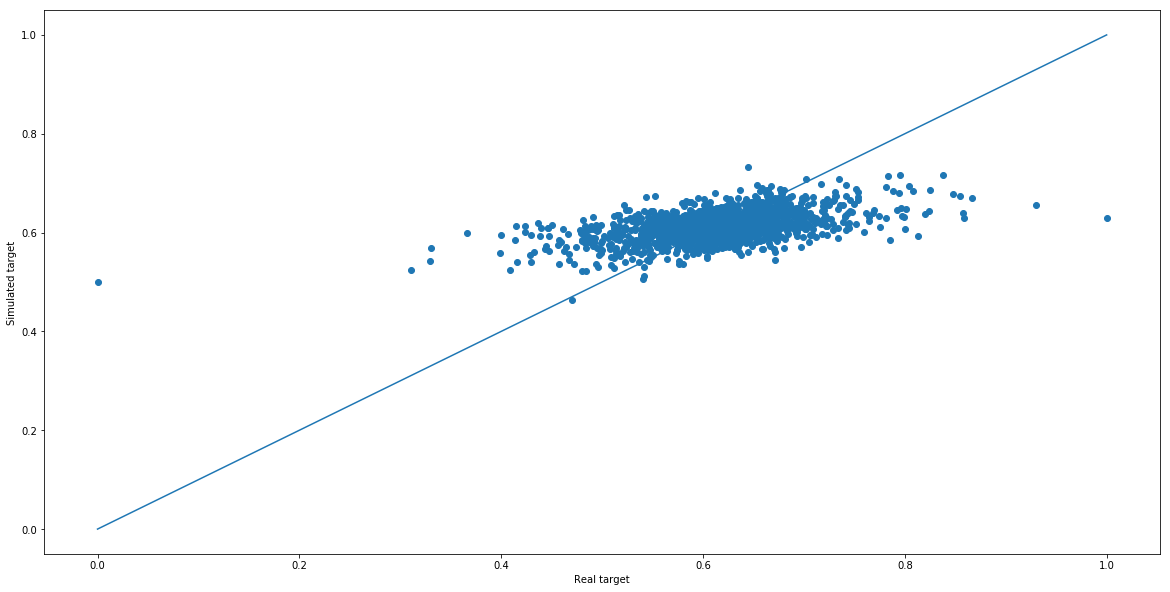

In [40]:
plt.figure(figsize=(20,10))
stats.describe(new_targets)
plt.scatter(new_targets,y_train_pred)
plt.plot([0,1],[0,1])
plt.xlabel('Real target')
plt.ylabel('Simulated target')

The preliminary model tends to overestimate the small values while underestimate the large values. More efforts will be devoted to build a more accurate model. For example, more than one of previous data points can be used to predict the return for current time step. For that, a neural net with LSTM architechture will be used next. 

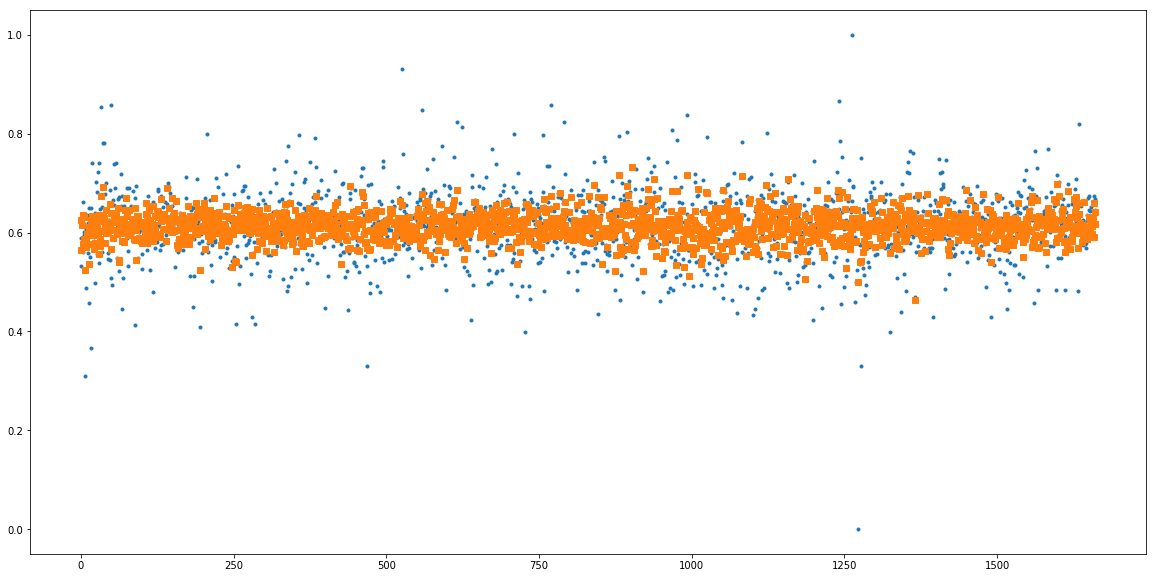

In [41]:
plt.figure(figsize=(20,10))
plt.plot(new_targets,'.')
stats.describe(new_targets)
#plt.figure(figsize=(20,12))
plt.plot(y_train_pred,'s')

In [42]:
def inverseTransform(minV,maxV, new_target):
    return new_target*(maxV-minV)+minV

In [43]:
def Transform(minV,maxV, target):
    return (target-minV)/(maxV-minV)

In [44]:
def TotalReturn(returnRate):
    #totalRe[i]=(1+returnRate[0])*(1+returnRate[1])*...*(1+returnRate[i]), i =0 to n
    totalRe=[]
    for i in range(len(returnRate)):
        if i==0:
            temp=returnRate[i]+1
        else:
            temp=(returnRate[i]+1)*totalRe[i-1]
        totalRe.append(temp)
    return totalRe

In [45]:
newTarget_total=TotalReturn(targets_df[:,0])


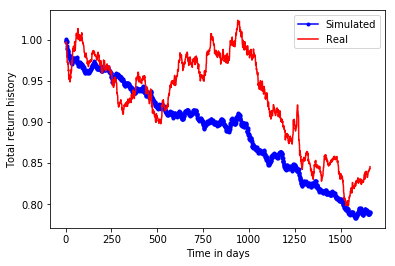

In [46]:
predict_invScale=inverseTransform(scaler.data_min_[0],scaler.data_max_[0], y_train_pred)
predict_total=TotalReturn(predict_invScale)
plt.figure()
plt.plot(predict_total,'.-b')
plt.plot(newTarget_total,'-r')
plt.xlabel('Time in days')
plt.ylabel('Total return history')
plt.legend(['Simulated','Real'])

# Decompose the importance of the 500 stocks with w vector for the duplication of Target 1

In [47]:
from scipy import linalg

In [48]:
w, res, rnk, s =linalg.lstsq(all_inputs_rec, y_train_pred)

#Try to decompose the relative importances of the 500 strategies with W vector (in 500*1)

In [49]:
new=np.matmul(all_inputs_rec,w)

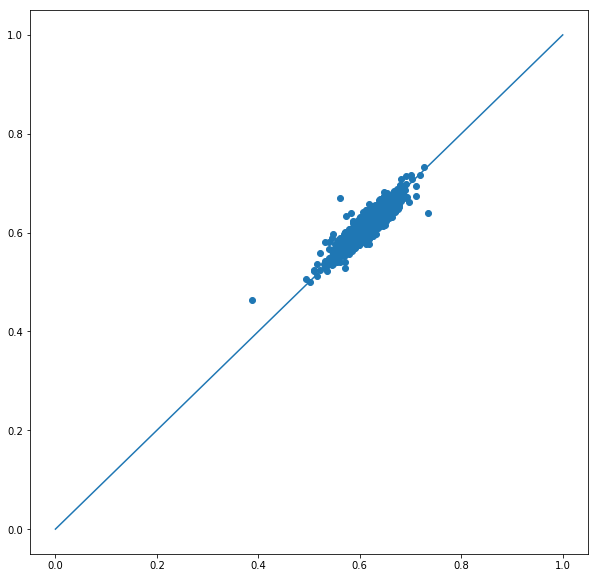

In [50]:
plt.figure(figsize=(10,10))
plt.scatter(new,y_train_pred)
plt.plot([0,1],[0,1])


0.61295015

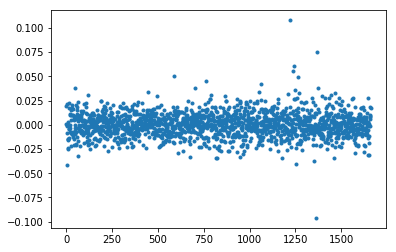

In [51]:
plt.plot(y_train_pred-new,'.')
np.mean(y_train_pred)

Most of the errors between trained results by neural net and the sequence by the product of all 500 strategies (all_inputs_rec) and the weights w are relative small, less than 0.025/np.mean(y_train_pred), which is less than 5%.